In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

## Preprocessing Train for Modeling 

In [2]:
test = pd.read_csv('datasets/base_test.csv')

In [3]:
train = pd.read_csv('datasets/base_train.csv')
train

,Unnamed: 0,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,0,109,533352170,60,RL,0.0,13517,Pave,None,IR1,...,0,0,None,None,None,0,3,2010,WD,130500
1,1,544,531379050,60,RL,43.0,11492,Pave,None,IR1,...,0,0,None,None,None,0,4,2009,WD,220000
2,2,153,535304180,20,RL,68.0,7922,Pave,None,Reg,...,0,0,None,None,None,0,1,2010,WD,109000
3,3,318,916386060,60,RL,73.0,9802,Pave,None,Reg,...,0,0,None,None,None,0,4,2010,WD,174000
4,4,255,906425045,50,RL,82.0,14235,Pave,None,IR1,...,0,0,None,None,None,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2046,1587,921126030,20,RL,79.0,11449,Pave,None,IR1,...,0,0,None,None,None,0,1,2008,WD,298751
2047,2047,785,905377130,30,RL,0.0,12342,Pave,None,IR1,...,0,0,None,None,None,0,3,2009,WD,82500
2048,2048,916,909253010,50,RL,57.0,7558,Pave,None,Reg,...,0,0,None,None,None,0,3,2009,WD,177000
2049,2049,639,535179160,20,RL,80.0,10400,Pave,None,Reg,...,0,0,None,None,None,0,11,2009,WD,144000


In [4]:
features = ['overall_qual', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'full_bath', 'fireplaces', 'garage_area', 
                 'totrms_abvgrd','lot_area', 'bldg_type', 'exter_cond', 'fence', 'saleprice']      

test_features = ['overall_qual', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'full_bath', 'fireplaces', 'garage_area', 
                 'totrms_abvgrd','lot_area', 'bldg_type', 'exter_cond', 'fence']   

In [5]:
train = train[features]

In [6]:
#removing outliers in lot_area greater than 30_000
train = train.loc[train['lot_area' ]< 30_000]

In [7]:
#removing outliers in total_bsmt_sf greater than 3000
train = train.loc[train['total_bsmt_sf'] < 3000]

In [8]:
#removing full_baths over 3
train = train.loc[train['full_bath'] <= 3]

In [9]:
#removing total_rooms_abvgrd over 12
train = train.loc[train['totrms_abvgrd'] <= 12]

In [10]:
#creating total_sf feature, which will capture both 1st and 2nd floor sf
#2nd floor sf had a lot of zeros, this will fix those zeros while still capturing the interaction with price
train['total_sf'] = train['1st_flr_sf'] + train['2nd_flr_sf']
train.drop(columns=['1st_flr_sf', '2nd_flr_sf'], inplace=True)

In [11]:
train.head()

,overall_qual,total_bsmt_sf,gr_liv_area,full_bath,fireplaces,garage_area,totrms_abvgrd,lot_area,bldg_type,exter_cond,fence,saleprice,total_sf
0,6,725.0,1479,2,0,475.0,6,13517,1Fam,TA,None,130500,1479
1,7,913.0,2122,2,1,559.0,8,11492,1Fam,TA,None,220000,2122
2,5,1057.0,1057,1,0,246.0,5,7922,1Fam,Gd,None,109000,1057
3,5,384.0,1444,2,0,400.0,7,9802,1Fam,TA,None,174000,1444
4,6,676.0,1445,2,0,484.0,6,14235,1Fam,TA,None,138500,1445


In [12]:
train.shape

(2019, 13)

In [15]:
test = test[test_features]
test.shape

(878, 13)

In [17]:
test['total_sf'] = test['1st_flr_sf'] + test['2nd_flr_sf']
test.drop(columns=['1st_flr_sf', '2nd_flr_sf'], inplace=True)

In [18]:
train = pd.get_dummies(train, drop_first=True)

In [19]:
test = pd.get_dummies(test, drop_first=True)

In [20]:
train.shape, test.shape

((2019, 22), (878, 21))

## Model 

In [675]:
X = train.drop(columns='saleprice')
y = train['saleprice']

In [676]:
X_train, X_test, y_train, y_test = train_test_split(X,y) 

In [677]:
lr = LinearRegression()

In [678]:
lr.fit(X_train, y_train)

LinearRegression()

In [679]:
#score are within 0.02 and relatively high, implies good variance trade-off
print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))

0.8226524895617633
0.8322440781993763


In [800]:
#on average the base_model is off by 31937
mean_squared_error(y_test, lr.predict(X_test), squared=False)

31937.38769854642

Text(0, 0.5, 'True Price')

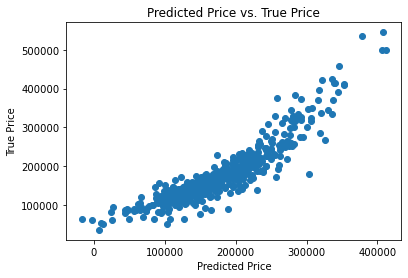

In [802]:
#model is strong for houses below $200_000, needs work for houses over 200_000
plt.scatter(lr.predict(X_test), y_test)
plt.title('Predicted Price vs. True Price')
plt.xlabel('Predicted Price')
plt.ylabel('True Price')

In [23]:
coef_dict = pd.DataFrame({'Coefficient' : lr.coef_, 'Feature' : X.columns})
coef_dict

In [775]:
len(X.columns)

21

In [680]:
#creating a pipeline to make poly, scale, and lasso each feature
#also gridsearching to pick model with best alpha
pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), Lasso())

param_grid = {
    'lasso__alpha':[0.01, 0.1, 0.5, 1, 10]
}

In [681]:
grid = GridSearchCV(pipe, param_grid)

In [682]:
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375215640933.8602, tolerance: 759842627.6007537
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337966006012.89496, tolerance: 749230722.4350715
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366624976271.93994, tolerance: 743036496.9482133
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarn

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.1, 0.5, 1, 10]})

In [683]:
#these scores are still close together, but higher than the base_model
#this implies a stronger model as well as a good balance between bias and variance
gr_train_score = grid.score(X_train, y_train)
gr_test_score = grid.score(X_test, y_test)

gr_train_score, gr_test_score

(0.897744698448995, 0.8813652989654395)

In [762]:
#the model produced a lower RMSE, implying the model's errors are smaller and the model is performing better 
#than the base_model
mean_squared_error(y_test, grid.predict(X_test), squared=False)

26121.175211685426

In [684]:
#the best alpha was 10
#this is my strongest model 
grid.best_estimator_

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=10))])

In [685]:
y_preds = grid.predict(test)

In [737]:
#noticed 2 of the predicted test values were below 0, im going to manually change them to zero to aviod a large
#error terms
edit_preds = []

In [741]:
for i in range(0, 878):
    if y_preds[i] < 0:
        edit_preds.append(train_mean)
    else:
        edit_preds.append(y_preds[i])

In [746]:
#after changinig these negative values to 0,
#my models average home price for the test-data was 178767, with a standard.dev of 75143, 
#somewhat similar to the training data
np.std(edit_preds), np.mean(edit_preds)

(75143.09297359001, 178767.1680881613)

In [747]:
sub = pd.read_csv('datasets/test.csv')
sub.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [748]:
submission = pd.DataFrame(sub['Id'])

In [749]:
submission['SalePrice'] = edit_preds

In [750]:
submission['SalePrice'].mean(), submission['SalePrice'].std()

(178767.16808816115, 75185.92175619166)

In [751]:
submission.to_csv('submission_d.csv', index=False)